# 2019102039, Pavan Kalyan Pennapati
# Seam carving

### Question - A

In [44]:
import cv2
import numpy as np
import time
from numba import jit
from tabulate import tabulate
from matplotlib import pyplot as plt
#added required libraries

In [45]:
#This function returns the energy value in each cell of the input matrix(the matrix form of the given image)
@jit #added @jit to execute the code quickly
def calculate_energy(img):
    rows = len(img)
    cols = len(img[0])
    #initialising a matrix for storing the energy values
    energy = [[0 for i in range(cols)] for j in range(rows)]
    for i in range(0,rows):
        for j in range(0,cols):
            hor = 0
            ver = 0
            #energy of a cell is: the sum of the squared differences of three colors of four adjacent cells(horizontally and vertically) with respect to the current cell
            #red, green, blue are the variables store rgb values of the current cell respectively
            red, green, blue = (img[i][j][0],img[i][j][1],img[i][j][2])
            if(j != 0):
                #l_r,l_g,l_b(left cell's red, left cell's green, left cell's blue) store the rgb values of the left cell
                l_r, l_g, l_b = (img[i][j-1][0],img[i][j-1][1],img[i][j-1][2])
                #adding the squared differences to the variable which stores the horizontal differences
                hor += ((red - l_r) * (red - l_r)) + ((green - l_g) * (green - l_g)) + ((blue - l_b) * (blue - l_b))
            if(j < (cols - 1)):
                #r_r,r_g,r_b store the rgb values of the right cell
                r_r, r_g, r_b = (img[i][j+1][0],img[i][j+1][1],img[i][j+1][2])
                #adding the squared differences to the variable which stores the horizontal differences
                hor += ((red - r_r) * (red - r_r)) + ((green - r_g) * (green - r_g)) + ((blue - r_b) * (blue - r_b))
            if(i != 0):
                #u_r,u_g,u_b store the rgb values of the cell up
                u_r, u_g, u_b = (img[i-1][j][0],img[i-1][j][1],img[i-1][j][2])
                #adding the squared differences to the variable which stores the vertical differences
                ver += ((red - u_r) * (red - u_r)) + ((green - u_g) * (green - u_g)) + ((blue - u_b) * (blue - u_b))
            if(i < (rows - 1)):
                #d_r,d_g,d_b store the rgb values of the cell down
                d_r, d_g, d_b = (img[i+1][j][0],img[i+1][j][1],img[i+1][j][2])
                #adding the squared differences to the variable which stores the vertical differences
                ver += ((red - d_r) * (red - d_r)) + ((green - d_g) * (green - d_g)) + ((blue - d_b) * (blue - d_b))
            #adding the both horizontal difference and vertical difference and storing in the energy matrix
            energy[i][j] = hor + ver
    return energy

# Finding seams
The below function returns a matrix called 'dp'. dp[i][j] tells us, what is the minimum energy value of a valid path till this cell(i,j) from the top most row. To find this, we are using dynamic programming here.
Given that, a path can be formed from one cell in one row to next row by connecting the present cell to either of three adjacent cells in the next row(3 cells in total, one is the bottom cell, remaning two are the left and right side cells of the bottom cell)

In [46]:
@jit
def seams(energy):
    rows = len(energy)
    cols = len(energy[0])
    dp = [[0 for i in range(cols)] for j in range(rows)]
    #For the first row, the minimum energy values of a valid path will be the same because there are no rows above the first row
    #So, just copying the same values into the dp matrix from the energy matrix
    for i in range(cols):
        dp[0][i] = energy[0][i]
    #Finding for the remaining cells in the remaining rows
    for i in range(1,rows):
        for j in range(0,cols):
            #storing the energy value of the current cell into the dp matrix
            dp[i][j] = energy[i][j];
            #Finding the minimum energy from the three available paths(one from top cell, another from top-left cell, another from top-right cell)
            dp[i][j] += dp[i - 1][j];
            if(j != 0):
                dp[i][j] = min(dp[i][j],energy[i][j]+dp[i - 1][j - 1])
            if(j < (cols - 1)):
                dp[i][j] = min(dp[i][j],energy[i][j]+dp[i - 1][j + 1])
    return dp

# Clearing the seam path, which has the low energy among the all possible seam paths:

In [47]:
#img is the matrix form of the image, and visited tells us which cells are belong the seam path
def clear_seam_path(img,visited):
    rows = len(img)
    cols = len(img[0])
    #Creating another matrix to store the matrix with removal of the seam path
    temp = [[0 for i in range(cols - 1)] for j in range(rows)]
    col = 0
    for i in range(rows):
        col = 0
        for j in range(cols):
            #We are storing the cells of the matrix-img which are not in the visited matrix(that means which are not in the seam path)
            if(visited[i][j] != 1):
                temp[i][col] = img[i][j]
                col = col + 1
    return temp

In [48]:
@jit
def convert_to_64_int(img):
    n = len(img)
    m = len(img[0])
    converted = [[[0 for k in range(3)] for i in range(m)] for j in range(n)]
    for i in range(n):
        for j in range(m):
            converted[i][j] = [np.dtype('int64').type(img[i][j][0]),np.dtype('int64').type(img[i][j][1]),np.dtype('int64').type(img[i][j][2])]
    return converted

In [49]:
@jit
def transpose(img):
    temp = [[img[k][i] for k in range(len(img))] for i in range(len(img[0]))]
    return temp

# seam_carving function takes matrix-form of the original image and a number(the number of seam paths to be cleared)

In [50]:
def seam_carving(original_img,number):
    if(number == 0):
        return original_img
    n = len(original_img)
    m = len(original_img[0])
    #The inbuilt-function original_img = cv2.imread(path) returns the matrix(original_img) of type (int8).
    #To do calculations without any overflows, we are storing the same matrix into another but with type (int64)
    #We can typecast using the command: new_x = np.dtype('int64').type(x), x is a 8bit number and new_x is a 64bit number
    original_img = np.array(original_img)
    img = convert_to_64_int(original_img)

    #Now, img matrix is of type (int64)
    for itr in range(number):
        rows = len(img)
        cols = len(img[0])
        
        # Calculating energy of each pixel
        img = np.array(img)
        
        #storing the time before calling the calculate_energy function
        time_0 = time.perf_counter()
        energy = calculate_energy(img) #Calling the calculate_energy function to get energy values 
        #storing the time after the above function is completed
        time_1 = time.perf_counter()
        #Printing the total time taken(difference between the time_1 and time_0) by the enegy function
#         print("For the seam removal - %d, it took %f seconds for energy calculation"%(itr+1,time_1-time_0))
        
        # Finding the least possible sum of energies in a path from top row to any cell in the matrix
        energy = np.array(energy)
        
        time_0 = time.perf_counter()
        dp = seams(energy) #Calling the seams function
        time_1 = time.perf_counter()
        #Printing the time taken by seams function
#         print("For the seam removal - %d, it took %f seconds for finding seams"%(itr+1,time_1-time_0))

        #visited matrix created to tell which cells are in the seam path
        visited = [[0 for k in range(cols)] for j in range(rows)]
        
        ### We'll find a seam path which has the minimum sum of all energies in the path
        
        #We want the minimum energy seam path, so we take the minimum value of energy in the last row of dp matrix
        min_path_sum = min(dp[rows - 1])
        #seam_path stores the cells of a seam path
        seam_path = [[0 for i in range(0,2)] for j in range(0,len(dp))]
        cell_col = dp[rows - 1].index(min_path_sum) #column of the cell at which the energy value is minimum
        
        #storing the cell [last_row,cell_col] in seam_path matrix
        seam_path[rows - 1] = [rows - 1,cell_col]
        visited[rows - 1][cell_col] = 1 # As we stored the last cell, we are marking that cell as visited
        temp_img = img #storing this to just print seam path after
        temp_img[rows-1][cell_col] = [255,255,255] #recoloring the last cell of the path with white color
        
        #We have the last cell of the seam path, now we'll find the remaining cells
        for i in range(rows-1,0,-1):
            #check that from which cell of the above row, we come to this value at dp[i][j]
            #After finding that cell, mark that cell in the visited matrix, store that cell in the seam_path matrix,
            #recolor that cell in the temp_img matrix
            if((cell_col != 0) and (dp[i - 1][cell_col - 1] + energy[i][cell_col] == dp[i][cell_col])):
                temp_img[i-1][cell_col-1] = [255,255,255]
                seam_path[i - 1] = [i-1,cell_col-1]
                visited[i - 1][cell_col - 1] = 1
                cell_col = cell_col - 1
            elif((cell_col != (cols - 1)) and (dp[i - 1][cell_col + 1] + energy[i][cell_col] == dp[i][cell_col])):
                temp_img[i-1][cell_col+1] = [255,255,255]
                seam_path[i - 1] = [i-1,cell_col+1]
                visited[i - 1][cell_col + 1] = 1
                cell_col = cell_col + 1
            else:
                temp_img[i-1][cell_col] = [255,255,255]
                seam_path[i - 1] = [i-1,cell_col]
                visited[i - 1][cell_col] = 1
        
        time_0 = time.perf_counter()
        img = clear_seam_path(img,visited)
        time_1 = time.perf_counter()
        #Printing the time taken by clear_seam_path function
#         print("For the seam removal - %d, it took %f seconds for clearing one seam path"%(itr+1,time_1-time_0))
        
        #Printing the seam path in the image
#         print("Seam path which is going to be removed")
#         plt.imshow(temp_img)
#         plt.show()

    return img

The orignal image is:


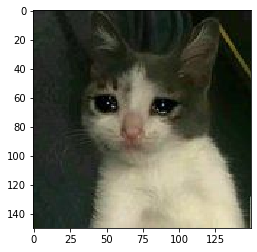

Image- images/cat.jpg
Time taken for 20 percent is 2.074965


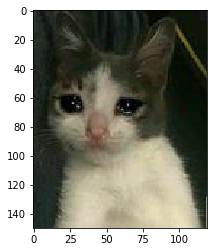

Time taken for 40 percent is 1.135089


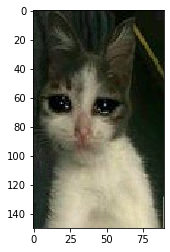

Time taken for 60 percent is 1.668382


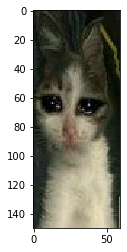

The orignal image is:


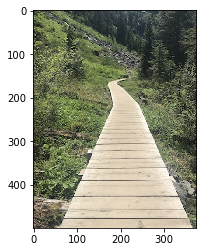

Image- images/path.jpg
Time taken for 20 percent is 19.592480


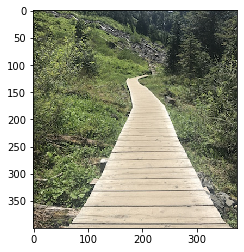

Time taken for 40 percent is 44.636413


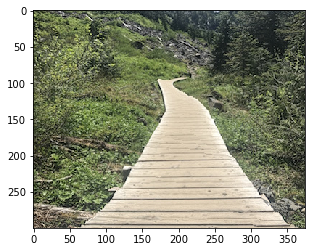

Time taken for 60 percent is 65.356889


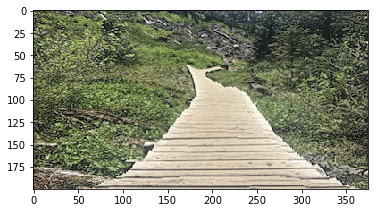

The orignal image is:


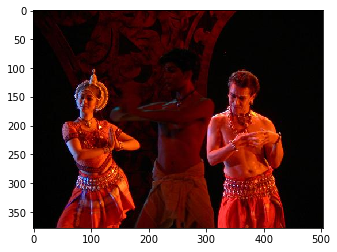

Image- images/bangalore-dancers.jpg
Time taken for 20 percent is 28.245005


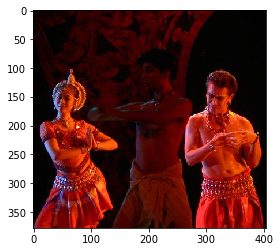

Time taken for 40 percent is 56.887143


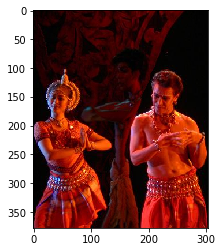

Time taken for 60 percent is 80.646904


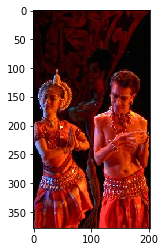

The orignal image is:


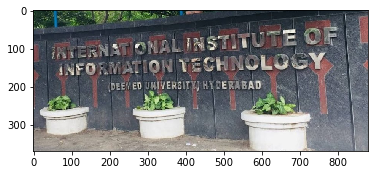

Image- images/iiit.jpg
Time taken for 20 percent is 105.271729


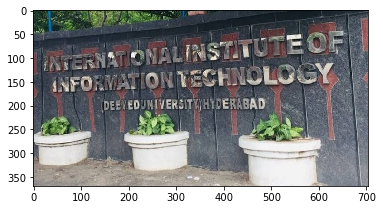

Time taken for 40 percent is 188.437731


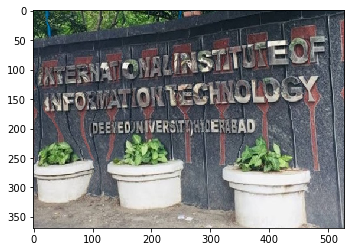

Time taken for 60 percent is 243.077663


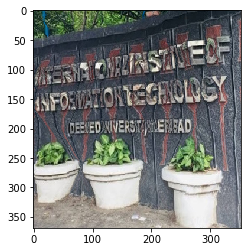

The orignal image is:


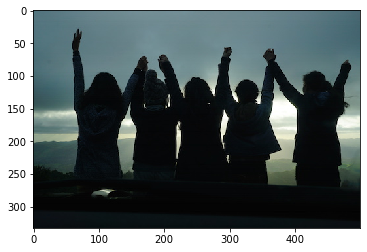

Image- images/shadow.jpg
Time taken for 20 percent is 29.402567


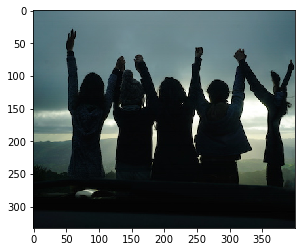

Time taken for 40 percent is 53.815321


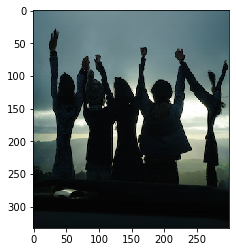

Time taken for 60 percent is 69.137107


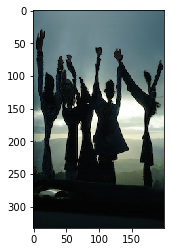

The orignal image is:


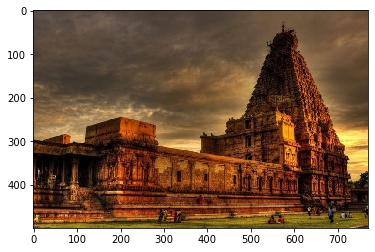

Image- images/tanjore.jpg
Time taken for 20 percent is 109.310963


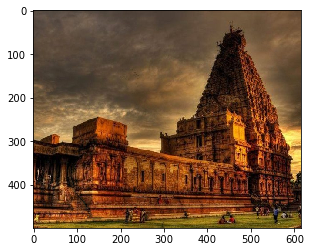

Time taken for 40 percent is 190.054352


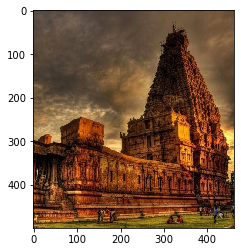

Time taken for 60 percent is 243.280908


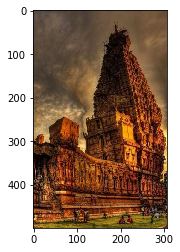

The orignal image is:


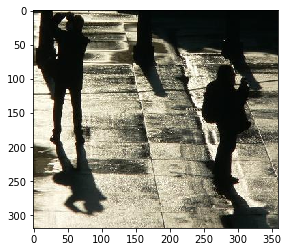

Image- images/trafalgar-square.jpg
Time taken for 20 percent is 14.115518


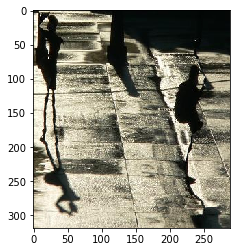

Time taken for 40 percent is 25.946013


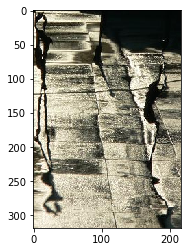

Time taken for 60 percent is 35.004684


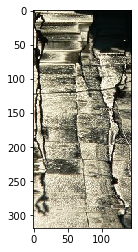

The orignal image is:


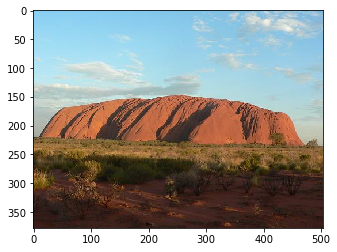

Image- images/uluru.jpg
Time taken for 20 percent is 36.233905


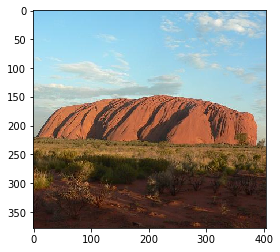

Time taken for 40 percent is 58.248798


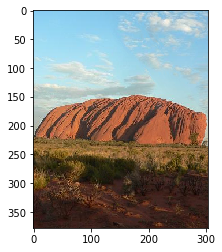

Time taken for 60 percent is 82.328625


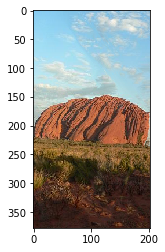

The orignal image is:


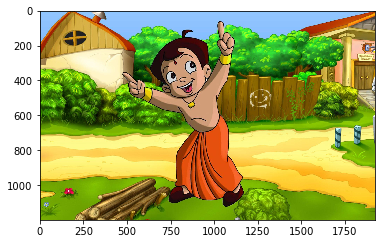

Image- images/chhota-bheem.jpg
Time taken for 20 percent is 1461.748019


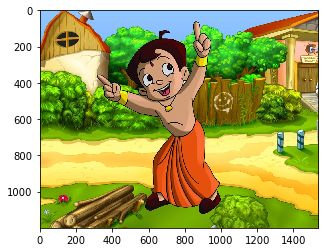

Time taken for 40 percent is 2743.527404


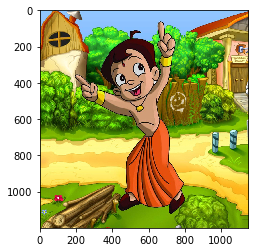

Time taken for 60 percent is 3280.962377


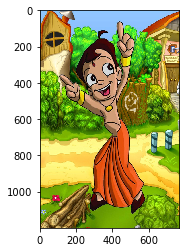

In [51]:
#storing the starting time of the program
start_time = time.perf_counter()
paths = ["images/cat.jpg","images/path.jpg","images/bangalore-dancers.jpg","images/iiit.jpg","images/shadow.jpg","images/tanjore.jpg","images/trafalgar-square.jpg","images/uluru.jpg","images/chhota-bheem.jpg"]
# path = "/home/pa1/Desktop/UG3/Algo_and_OS/Assignment-2/images/cat.jpg" #location of the image
percents = [0.2,0.4,0.6]
percentages = [20,40,60]
for i in range(len(paths)):
    path = paths[i]
    #converting image into matrix
    original_img = cv2.imread(path,1)
    #image got converted with format BGR, so we are changing that format as RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) 
    print("The orignal image is:")
    plt.figure('Original Image')
    plt.imshow(original_img)
    plt.show()
    
    if(i == 1):
        original_img = np.array(original_img)
        original_img = transpose(original_img)
    
    print("Image-",path)
    ind = -1
    for j in percents:
        ind = ind + 1
        number = np.dtype('int64').type(j*len(original_img[0]))
        start_time = time.perf_counter()
        img = seam_carving(original_img,number)
        end_time = time.perf_counter()
        if(i == 1):
            img = np.array(img)
            img = transpose(img)
        print("Time taken for %d percent is %f"%(percentages[ind],end_time-start_time))
        plt.imshow(img)
        plt.show()

#### Table of times taken by all images

In [1]:
from prettytable import PrettyTable 
myTable = PrettyTable(["Image", "Time(sec) for 20%", "Time(sec) for 40%", "Time(sec) for 60%"]) 
# Add rows 
myTable.add_row(["cat", "0.7", "1.3", "1.7"]) 
myTable.add_row(["path ","19.59","44.63","65.35"]) 
myTable.add_row(["bangalore-dancers","28.2","56.8","80.64"]) 
myTable.add_row(["iiit","105","188","243"]) 
myTable.add_row(["shadow","29.4","53.8","69.13"]) 
myTable.add_row(["tanjore","109","190","243"])
myTable.add_row(["trafalgar-square","14","25.9","35"])
myTable.add_row(["uluru","36","58","82.3"])
myTable.add_row(["Chhota-bheem","1461","2743","3280"])
print(myTable)

+-------------------+-------------------+-------------------+-------------------+
|       Image       | Time(sec) for 20% | Time(sec) for 40% | Time(sec) for 60% |
+-------------------+-------------------+-------------------+-------------------+
|        cat        |        0.7        |        1.3        |        1.7        |
|       path        |       19.59       |       44.63       |       65.35       |
| bangalore-dancers |        28.2       |        56.8       |       80.64       |
|        iiit       |        105        |        188        |        243        |
|       shadow      |        29.4       |        53.8       |       69.13       |
|      tanjore      |        109        |        190        |        243        |
|  trafalgar-square |         14        |        25.9       |         35        |
|       uluru       |         36        |         58        |        82.3       |
|    Chhota-bheem   |        1461       |        2743       |        3280       |
+---------------

### Question - B

### Give a big-O analysis of your solution. Find an upper bound on the total number of possible vertical seams for an image in terms of its width and height. Use this bound to find the time complexity of the naive solution which computes the energy for every possible seam.

Ans) Let "R" be the number of horizontal pixels and "C" be the number of vertical pixels of an image.
     Let "N" be the number of seams to be removed
     The Time Complexity of my solution is O(N x (R x C)).
     
     The upper bound on the total number of possible vertical seams for an image is:
     A seam can be formed by connecting one cell in one row to any of the three cells in its next row. So, three possibiltes are there. And if we chose any one of the three, now we have another three possibilities in the next row. So, it will be exponential. The length of any vertical seam is nothing but "R". Choosing any of three cells available starts from the second row. That means, (R - 1) rows. So, the upper bound on vertical seams is (cols x (3^(R - 1))).
     
     To find the energy of a seam naively we need R iterations. So, the overall time complexity for every possible seam is O(R x C x 3^(R - 1))

### Question - C
### 1. Will the result be the same if the image is flipped upside down? What happens to the overall energy in the image during seam carving?
Ans) No, the result will be the same even if the image is flipped upside down. As we are calculating the energy of a cell based on its four adjacent cells, even if we flip the image, the adjacent cells will be the same. So, nothing changes.
### 2. Suppose we want to resize the image in both the dimensions, should we remove the horizontal seams first, or remove the vertical seams first, or should we alternate between the two, or are there any optimal order?
Ans) Find one minimum energy seam vertically and one minimum energy seam horizontally. If the horizontal seam has the minimum energy than vertical seam, then remove the horizontal seam, otherwise do viceversa. We need to take of the number of vertical seams, horizontal seams to be removed. Depending on this, we follow the above approach. 